In [0]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [0]:
from collections import deque
from sklearn.model_selection import train_test_split
from tflearn.data_utils import to_categorical
import tflearn
import numpy as np
import pickle
from keras.models import load_model

In [0]:
num_frames_per_segment = 25
# input_length = 2048
input_length = 4032
num_classes = 2

In [0]:
X, y = [], []
with open("/gdrive/My Drive/hackathon/transfer_value/sex_nas_ver2.pkl","rb") as f:
  unpickler = pickle.Unpickler(f)
  pkl = unpickler.load()
  data = pkl['data']
  label = pkl['label']
  print(len(data), len(label))
  for i in range(len(data)):
    X.append(np.array(data[i]))
    y.append(label[i])
  f.close()
X = np.array(X)
# Y = np.array(y)
print(y[:5], y[-5:])
X = X.reshape(-1, num_frames_per_segment, input_length)
temp_y = []
for i in range(len(X)):
  temp_y.append(y[(i+1)*num_frames_per_segment-1])

y = np.array(temp_y)
y = to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

85150 85150
[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]


In [0]:
y = np.array(temp_y)
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [2142 1264]


In [0]:
print(len(y))

3406


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, GRU, TimeDistributed

def lstm_model(time_steps=25, input_length=4032, num_class=2):
  model = Sequential()
  model.add(LSTM(512, input_shape=(time_steps, input_length), return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(512, return_sequences = True))
  model.add(Dropout(0.3))
  model.add(LSTM(512))
  model.add(Dropout(0.3))
  model.add(Dense(1024))
  model.add(Activation('relu'))
  model.add(Dropout(0.3))
  model.add(Dense(50))
  model.add(Activation('sigmoid'))
  model.add(Dense(num_class))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model
  

In [0]:
# from keras.utils import plot_model
# model = lstm_model()
# plot_model(model, to_file='model.png')

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('/gdrive/My Drive/hackathon/model1.1.h5', verbose=1, save_best_only=True)

In [0]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=64):
    model = None
    model = lstm_model()
    results = model.fit(t_x, t_y, validation_data=(val_x, val_y), epochs=EPOCHS, batch_size=BATCH_SIZE, 
                        callbacks=[early_stopping, model_checkpoint], verbose=1)  
    test_score = model.evaluate(X_test, y_test)
    print("Test Score: ", test_score)
    return results

In [21]:
epochs_per_fold = 100
batch_size = 32
n_folds = 10

model_history = [] 
random_sates = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

for i in range(10):
  print("Training on Fold: ",i+1)
  t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=1/n_folds, 
                                             random_state = random_sates[i])
  model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs_per_fold, batch_size))
  print("======="*12, end="\n\n\n")

Training on Fold:  1


W0713 05:45:17.631939 140418691446656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 05:45:18.515333 140418691446656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0713 05:45:20.213156 140418691446656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0713 05:45:20.436236 140418691446656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: a

Train on 2758 samples, validate on 307 samples
Epoch 1/100
2758/2758 [==============================] - 30s 11ms/step - loss: 0.6694 - acc: 0.6204 - val_loss: 0.6484 - val_acc: 0.6515

Epoch 00001: val_loss improved from inf to 0.64840, saving model to /gdrive/My Drive/hackathon/model1.1.h5
Epoch 2/100
2758/2758 [==============================] - 24s 9ms/step - loss: 0.6512 - acc: 0.6378 - val_loss: 0.6207 - val_acc: 0.6710

Epoch 00002: val_loss improved from 0.64840 to 0.62073, saving model to /gdrive/My Drive/hackathon/model1.1.h5
Epoch 3/100
2758/2758 [==============================] - 23s 8ms/step - loss: 0.6063 - acc: 0.6849 - val_loss: 0.5973 - val_acc: 0.6906

Epoch 00003: val_loss improved from 0.62073 to 0.59733, saving model to /gdrive/My Drive/hackathon/model1.1.h5
Epoch 4/100
2758/2758 [==============================] - 24s 9ms/step - loss: 0.5482 - acc: 0.7462 - val_loss: 0.5551 - val_acc: 0.7199

Epoch 00004: val_loss improved from 0.59733 to 0.55509, saving model to /gd

KeyboardInterrupt: ignored

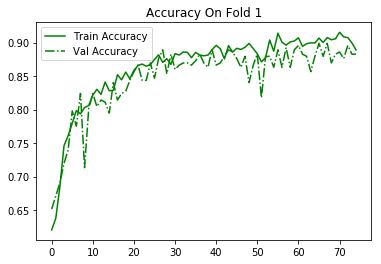

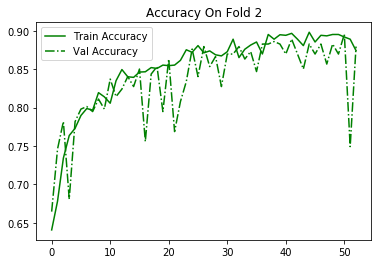

In [22]:
import matplotlib.pyplot as plt
for i in range(len(model_history)):
  plt.title('Accuracy On Fold %d'%(i+1))
  plt.plot(model_history[i].history['acc'], label='Train Accuracy', color='green')
  plt.plot(model_history[i].history['val_acc'], label='Val Accuracy', color='green', linestyle = "dashdot")
  plt.legend()
  plt.show()

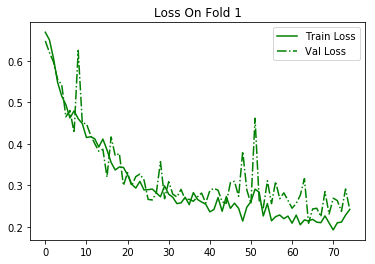

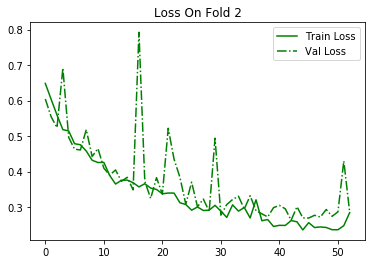

In [23]:
for i in range(len(model_history)):
  plt.title('Loss On Fold %d'%(i+1))
  plt.plot(model_history[i].history['loss'], label='Train Loss', color='green')
  plt.plot(model_history[i].history['val_loss'], label='Val Loss', color='green', linestyle = "dashdot")
  plt.legend()
  plt.show()

In [0]:
model = load_model('/gdrive/My Drive/hackathon/model.h5')

In [0]:
print(model.evaluate(X_test, y_test))